In [35]:
# Import Necessary Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, auc, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [29]:
# Load the Data
data = pd.read_csv('https://classfiles.blob.core.windows.net/files/creditcard.csv')

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

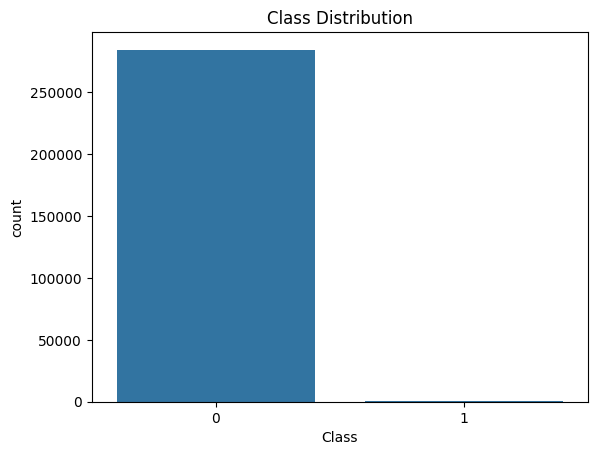

In [4]:
# View first few rows
print(data.head())

# Summary statistics
print(data.describe())

# Class distribution
print(data['Class'].value_counts())

# Plot class distribution
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

In [36]:
# Separate Features and Target Variable
X = data.drop('Class', axis=1)
y = data['Class']

In [37]:
# Initialize the scaler
# fit: Computes the mean and standard deviation of the features from the data.
# transform: Applies the scaling to the data using the computed mean and standard deviation.

# Why Scale 'Time' and 'Amount'?
# 1. Importance of Feature Scaling
#   Algorithm Performance: Many machine learning algorithms perform better when input features are on similar scales. Scaling can improve convergence speed and model performance.
#   Distance-Based Methods: Algorithms that use distance metrics (e.g., K-Nearest Neighbors) are sensitive to the scale of the data.
# 2. Characteristics of 'Time' and 'Amount'
# 'Time':
#   Represents the elapsed time in seconds between each transaction and the first transaction.
#   Can have a wide range of values.
# 'Amount':
#   Represents the transaction amount.
#   Can vary significantly between transactions.

# Effect on the Data
# Before Scaling:
#   Features may have different scales and units.
#   Could lead to biases in algorithms that are sensitive to feature scales.
# After Scaling:
#   Features are centered around zero.
#   Have unit variance.
#   Improves the performance of many algorithms.

# Make copy of unscaled data to use for comparison to scaled data later.
X_original = copy.deepcopy(X)

scaler = StandardScaler()
# Fit on the 'Amount' and 'Time' features
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

In [7]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [28]:
# Handle Class Imbalance with SMOTE
#   SMOTE (Synthetic Minority Over-sampling Technique) is an over-sampling method that generates synthetic samples of the minority class to balance the dataset.
# How Does SMOTE Work?
#   Select a Minority Class Sample:
#   For each sample in the minority class, SMOTE finds its k nearest neighbors (typically k = 5).
sm = SMOTE(random_state=42)

# resample=balance
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Verify the new class distribution
print(pd.Series(y_resampled).value_counts())

Class
0    227451
1    227451
Name: count, dtype: int64


In [9]:
# Train the Model
# How It Works
# Bootstrapping:
#   Each tree is trained on a bootstrapped sample (random sampling with replacement) of the training data.
#   This introduces diversity among the trees.
# Random Feature Selection:
#   At each node in a tree, a random subset of features is selected.
#   The best split is found only among these features.
#   This further reduces correlation among the trees.
# Tree Growth:
#   Each tree is grown to the largest extent possible (can be controlled by parameters).
#   No pruning is performed.
# Aggregation:
#   For classification, the final prediction is made by majority voting across all trees.
#   For regression, predictions are averaged.

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [11]:
# Make Predictions
# predict() Method
#   Function: Predicts the class labels for the input samples.
#   Process:
#       For classification models, the method uses the learned patterns from the training data to assign a class label to each sample.
#       In a Random Forest, each tree in the forest makes a prediction, and the final prediction is made by majority voting among all the trees.
#   Output: An array of predicted class labels.

# predict_proba() Method
#   Function: Predicts the class probabilities for the input samples.
#   Process:
#       The method computes the probability that a given sample belongs to each class.
#       In a Random Forest, the predicted probability for a class is the mean predicted probability of the trees in the forest.
#       Each tree outputs a probability estimate, and these are averaged to get the final probability.
#   Output: An array of shape (n_samples, n_classes) where each row corresponds to a sample and each column corresponds to a class.
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

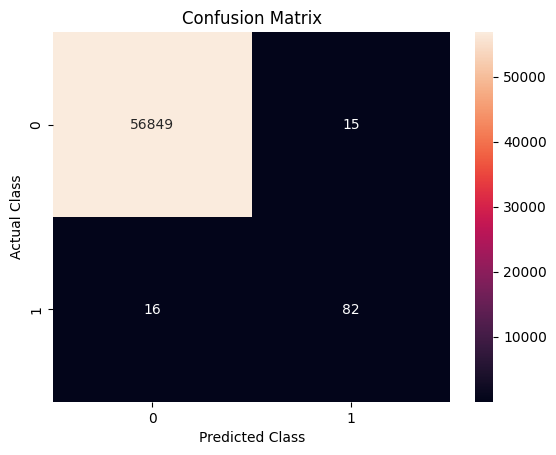

In [12]:
# Evaluate the Model
# The confusion matrix provides a summary of prediction results, 
# showing how many instances were correctly or incorrectly classified for each class. 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [13]:
# Classification Report
# Metrics for Class 0 (Non-Fraudulent Transactions)
#   Precision:
#       Near 0.99 or 1.00, indicating that almost all transactions predicted as non-fraudulent are actually non-fraudulent.
#   Recall:
#       Near 1.00, indicating that the model correctly identifies nearly all non-fraudulent transactions.
#   F1-Score:
#       High value (~0.99), reflecting the model's excellent performance on the majority class.
#   Support:
#       The number of non-fraudulent transactions in the test set (e.g., 56,864).

# Metrics for Class 1 (Fraudulent Transactions)
#   Precision:
#       For example, 0.91, meaning that 91% of transactions predicted as fraudulent are actually fraudulent.
#   Recall:
#       For example, 0.76, indicating that the model correctly identifies 76% of actual fraudulent transactions.
#   F1-Score:
#       A balanced measure (~0.83) considering both precision and recall.
#   Support:
#       The number of fraudulent transactions in the test set (e.g., 98).

# Macro Average
#   Definition: The arithmetic mean of the metric computed independently for each class.
#   Use Case:
#       Treats all classes equally, regardless of their support.
#       Useful when you want to evaluate the model's performance on each class equally.

# Weighted Average
#   Definition: The average of the metric, weighted by the number of true instances for each class (support).
#   Use Case:
#       Takes into account the imbalance in the dataset.
#       Reflects the overall performance considering the proportion of each class.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [14]:
# ROC AUC Score
# The ROC AUC (Receiver Operating Characteristic (ROC) Area Under the Curve) score is a metric used to 
# evaluate the performance of a binary classifier, measuring its ability to distinguish between the 
# two classes across all possible classification thresholds.
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

ROC AUC Score: 0.9731


In [15]:
# Precision-Recall Curve and AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
avg_precision = average_precision_score(y_test, y_pred_prob)
print(f'Precision-Recall AUC: {pr_auc:.4f}')
print(f'Average Precision Score: {avg_precision:.4f}')

Precision-Recall AUC: 0.8766
Average Precision Score: 0.8747


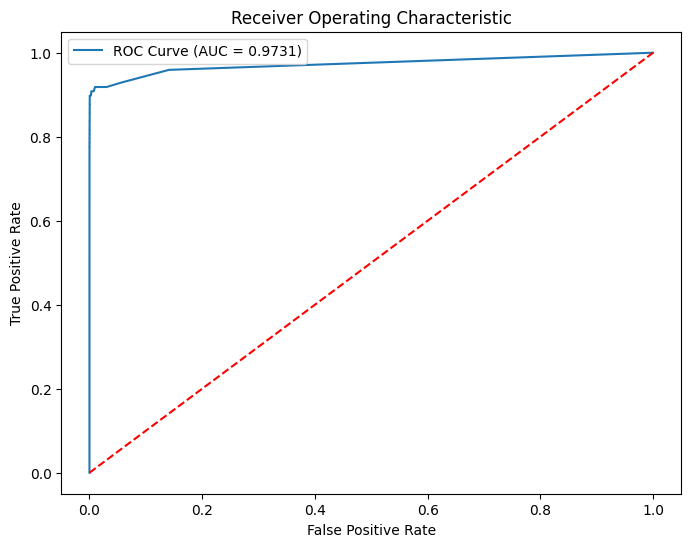

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

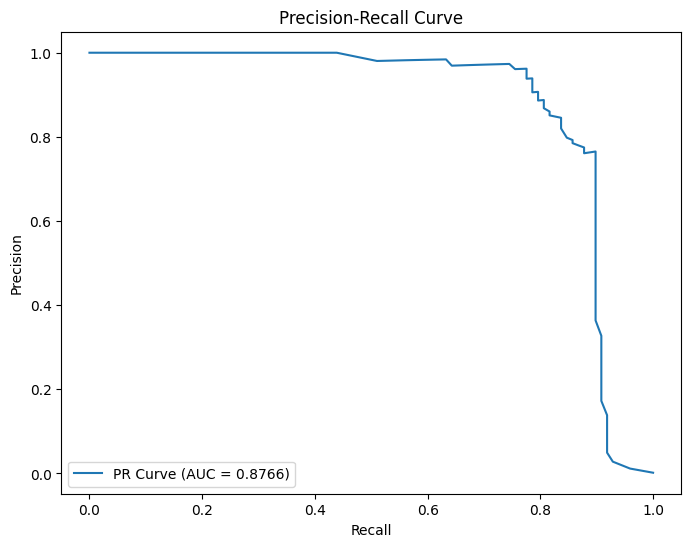

In [17]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [18]:
# Adjust Class Weights
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)

In [19]:
# Cross-Validation with Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    clf, X_resampled, y_resampled, cv=skf, scoring='roc_auc'
)
print(f'Cross-validated ROC AUC scores: {cv_scores}')
print(f'Mean ROC AUC score: {cv_scores.mean():.4f}')

Cross-validated ROC AUC scores: [0.99998718 0.99999999 0.99999984 0.99997558 0.99999967]
Mean ROC AUC score: 1.0000


In [20]:
import joblib

# Save the trained model
joblib.dump(clf, 'fraud_detection_model.pkl')

# Save the scaler
# When deploying the model, you need to apply the same scaling to new data.
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

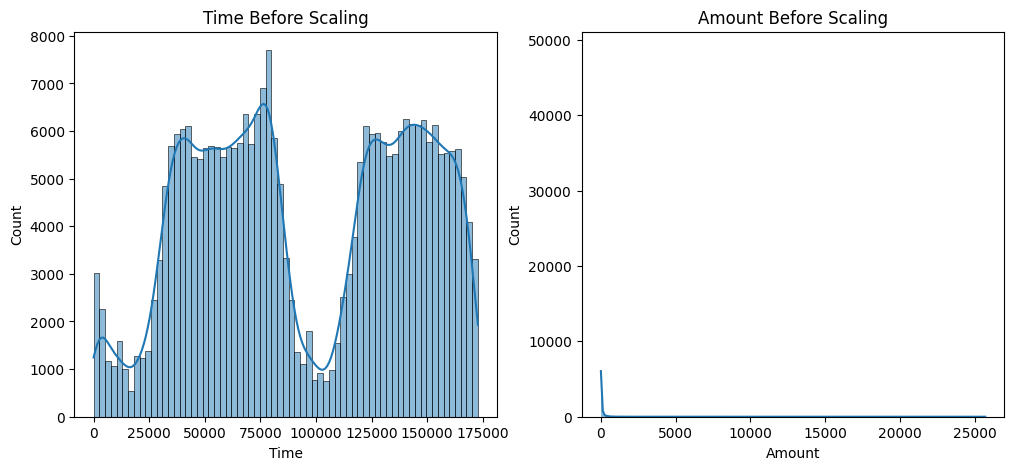

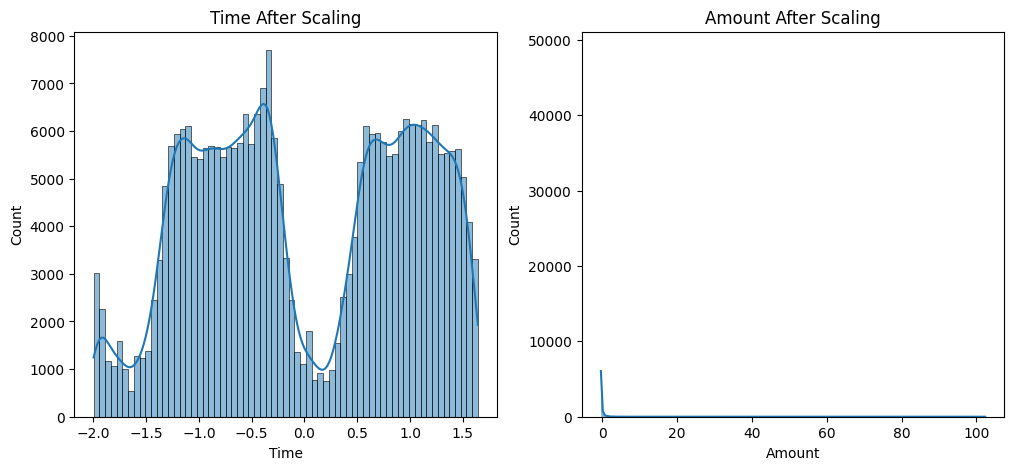

In [40]:
# Visualizing the Effect of Scaling

# Before scaling
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(X_original['Time'], ax=ax[0], kde=True)
ax[0].set_title('Time Before Scaling')
sns.histplot(X_original['Amount'], ax=ax[1], kde=True)
ax[1].set_title('Amount Before Scaling')
plt.show()

# After scaling
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(X['Time'], ax=ax[0], kde=True)
ax[0].set_title('Time After Scaling')
sns.histplot(X['Amount'], ax=ax[1], kde=True)
ax[1].set_title('Amount After Scaling')
plt.show()